# Vortex patch dynamics

In [1]:
using PotentialFlow

In [2]:
using Plots
pyplot()
default(grid = false)
tkfont = Plots.font("Times New Roman",15)

Plots.Font("Times New Roman", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

### Create the vortex evolution function
The following defines the function to compute the velocities of all vortex elements in the system

In [3]:
function compute_ẋ!(ẋ, x, t)
        
    # Zero the velocity
    reset_velocity!(ẋ, x)
    
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
end

compute_ẋ! (generic function with 1 method)

### Set up initial vortices

Now we will set up the vortex elements in the physical plane. Let's first set up some functions that create a circular patch of point vortices of specified position, size, and strength.

In [26]:
"""
    vortex_patch!(vort,zc,Γ,radius,nring[,δ=0])

Create a circular patch of vortex blobs, returned in `vort`. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
function vortex_patch!(vort,zc,Γ,radius,nring::Int;δ=0)
    Δr = radius/(nring-1/2)
    dΓ = Γ/(1+8*nring*(nring-1)/2)
    push!(vort,Vortex.Blob(zc,dΓ,δ))
    for ir in 1:nring-1
        nθ = 8*ir
        for j = 0:nθ-1
            push!(vort,Vortex.Blob(zc + ir*Δr*exp(im*2π*j/nθ),dΓ,δ))
        end
    end
    return vort
end

"""
    vortex_patch(zc,Γ,radius,nring[,δ=0]) -> Vector{Vortex.Blob}

Create a circular patch of vortex blobs. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
vortex_patch(zc,Γ,radius,nring::Int;δ=0) = vortex_patch!(Vortex.Blob{Float64,Float64}[],zc,Γ,radius,nring,δ=δ)

vortex_patch

We will set up two patches for this demonstration. Each will have 10 rings. You can play with any of these.

In [27]:
r0 = 0.3 # initial radius of the vortex patch
d0 = 1.0  # initial distance between patch centroids
Γ0 = 1.0 # strength of patch.
nring = 10   # number of rings in each patch.
Δt = 0.01*π^2*d0^2/abs(Γ0) # set the time step
δ = 0.05
nothing

Initialize the system and the velocity structure. Any time you wish to restart a problem, you will need to run the next two input lines. The system here is composed of two patches, one initially at (0,0.5d0) and the other at (0,-0.5d0), but you can change that, obviously. And you can easily add more patches into the system `sys`.

In [47]:
t = 0.0
sys = (vortex_patch(0.5im*d0,Γ0,r0,nring,δ=δ),
       vortex_patch(-0.5im*d0,Γ0,r0,nring,δ=δ))
npatch = length(sys)

2

No need to change anything in the following line. It just initializes a bunch of data structures for the problem.

In [48]:
# Used for storage during time-marching
sys₊ = deepcopy(sys) 

# Set up a velocity structure that will work for 4th-order Runge-Kutta
ẋs = [allocate_velocity(sys) for k = 1:4];

# To keep track of time
timp = Float64[]

# To keep track of element trajectories:
track = [ComplexF64[] for sysi in sys]

# To keep track of impulse in each patch
imp = [ComplexF64[] for sysi in sys]

append!(timp,t)
for (i,sysi) in enumerate(sys)
    append!(track[i],copy(Elements.position(sysi)))
    append!(imp[i],Elements.impulse(sysi))
end
nothing

Now perform the time marching. Note that you can run this repeatedly without resetting the system to its initial conditions. This allows you to check results occasionally.

In [49]:
tf = 3
T = 0:Δt:tf-Δt

for tloc in T
    TimeMarching.rk4!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    sys₊, sys = sys, sys₊
    
    t += Δt
    
    append!(timp,t)
    for (i,sysi) in enumerate(sys)
        append!(track[i],copy(Elements.position(sysi)))
        append!(imp[i],Elements.impulse(sysi))
    end
    
end
final_sys = sys;

### Plotting the system
The plot command is a bit slow the first time you run it. It's much faster after that...

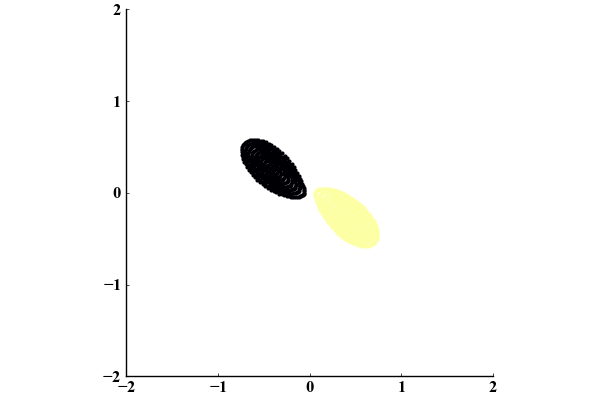

In [50]:
plot(ratio=1,legend=:none,xlims = (-2,2), ylims = (-2,2), markerstrokewidth=0, markersize=3, tickfont=tkfont)

# This plots patch number 1. The marker_z option gives the patch a distinct color.
plot!(final_sys[1],markerstrokewidth=0, markersize=3, marker_z = -1)

# This plots patch number 2
plot!(final_sys[2],markerstrokewidth=0, markersize=3, marker_z = 1)

#plot!(final_sys[3],markerstrokewidth=0, markersize=3, marker_z = 0.5)


# If you want to save a figure, you can use the savefig function
#savefig("FigName.pdf") 

### Plotting the pathlines of the vortex elements

Below we define a function that allows us to pick off the trajectory of a certain point vortex from ther collected `track` array. We specify it by its patch number and its ID number in the patch

In [51]:
trajectory(track,patch::Int,elementID::Int) =  elementID <= length(sys[patch]) ? track[patch][elementID:length(sys[patch]):end] : error("Element ID out of range")

trajectory (generic function with 1 method)

Let us plot the trajectory of one point vortex:

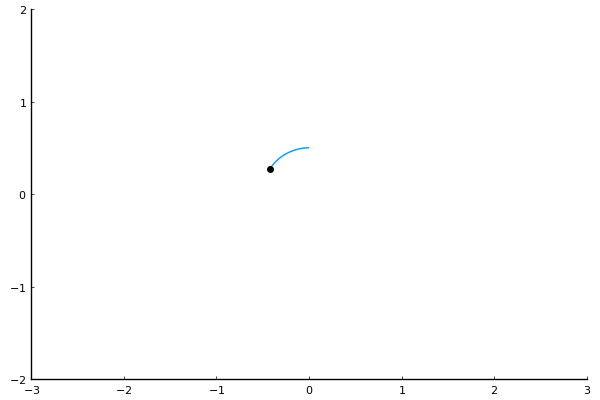

In [52]:
ps = plot(ratio=1,legend=:none,xlims = (-3,3), ylims = (-2,2));
patch = 1
elementID = 1
traj = trajectory(track,patch,elementID)
plot!(ps,real.(traj),imag.(traj));
plot!(ps,final_sys[patch][elementID:elementID])

### Plotting the impulses

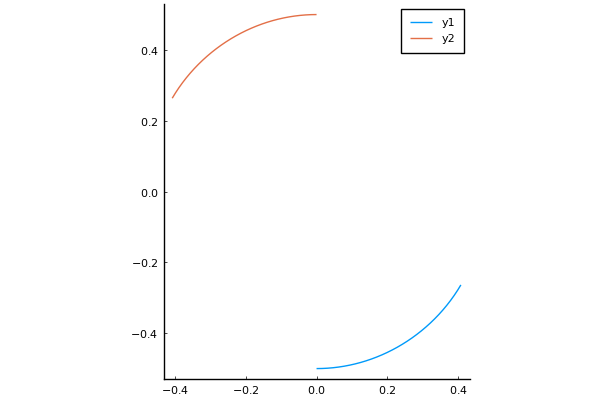

In [53]:
plot(imag.(imp[1])/Γ0,-real.(imp[1])/Γ0,ratio=1)
plot!(imag.(imp[2])/Γ0,-real.(imp[2])/Γ0,ratio=1)

#### Distance between patch centroids

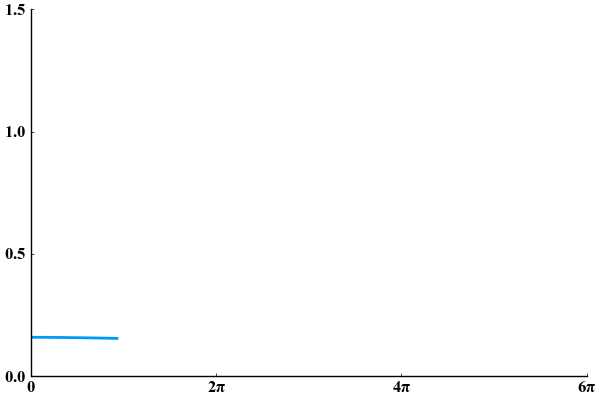

In [54]:
tkfont = Plots.font("Times New Roman",12)
plot(xlim=(0,6π),ylim=(0,1.5),xticks=(0:2π:6π,["0","2π","4π","6π"]),tickfont=tkfont,legend=:false)
plot!(Γ0*timp/d0^2,abs.(imp[1]-imp[2])/(2π),linewidth=2)
#savefig("CoRotateDCentroid.pdf")